In [1]:
import os
import getpass

os.environ['ANTHROPIC_API_KEY'] = ""
os.environ['OPENAI_API_KEY'] = ""

# turn on langsmith tracing
os.environ['LANGSMITH_API_KEY'] = ""
os.environ['LANGSMITH_TRACING_V2'] = "true"

In [2]:
# from langchain_anthropic import ChatAnthropic

# model = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [3]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

## Customer support tools

In [4]:
from typing_extensions import Annotated, Literal

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.types import Command, interrupt
from langgraph.prebuilt import InjectedState

import json

In [38]:
def get_state_or_config_key(state: dict, config: RunnableConfig, key: str, raise_if_missing: bool = True):
    user_id = state.get(key) or config.get("configurable", {}).get(key)
    if user_id is None and raise_if_missing:
        raise ValueError(f"{key} is missing")

    return user_id


USERS = [
    {"id": "1", "first_name": "John", "last_name": "Smith", "title": "Mr"},
    {"id": "2", "first_name": "Jane", "last_name": "Doe", "title": "Dr"},
    {"id": "3", "first_name": "Oliver", "last_name": "Smith", "title": "Dr"},
]

# super simplistic
FLIGHTS = [
    {"id": "1", "departure_airport": "BOS", "arrival_airport": "JFK", "airline": "Jet Blue", "date": "2024-11-19"},
    {"id": "2", "departure_airport": "BOS", "arrival_airport": "MIA", "airline": "American Airlines", "date": "2024-11-19"},
    {"id": "3", "departure_airport": "JFK", "arrival_airport": "BOS", "airline": "Jet Blue", "date": "2024-11-29"},
    {"id": "4", "departure_airport": "MIA", "arrival_airport": "BOS", "airline": "American Airlines", "date": "2024-11-29"},
]

# super simplistic (no available dates)
HOTELS = [
    {"id": "1", "location": "New York", "name": "McKittrick Hotel", "neighborhood": "Chelsea"},
    {"id": "2", "location": "New York", "name": "Hyatt", "neighborhood": "Midtown"},
    {"id": "3", "location": "Miami Beach", "name": "Nautilus Hotel", "neighborhood": "South Beach"},
]

# overall itinerary reservations
RESERVATIONS = [
    {
        "number": "1-123",
        "user_id": "1",
        "flight_id": "1",
        "hotel_id": "1",
        "hotel_start_date": "2024-11-19",
        "hotel_end_date": "2024-11-29"
    }
]


def expand_reservation(reservation):
    expanded_reservation = {**reservation}

    if flight_id := reservation.get("flight_id"):
        flight = [flight for flight in FLIGHTS if flight["id"] == flight_id][0]
        flight_info = {**flight}
        flight_info.pop("id")
        expanded_reservation["flight_info"] = flight_info

    if hotel_id := reservation.get("hotel_id"):
        hotel = [hotel for hotel in HOTELS if hotel["id"] == hotel_id][0]
        hotel_info = {**hotel}
        hotel_info.pop("id")
        expanded_reservation["hotel_info"] = hotel_info

    if flight_id is None and hotel_id is None:
        raise ValueError("Malformed reservation -- missing flight ID and hotel ID")

    return expanded_reservation


def get_reservation(state, config):
    user_id = get_state_or_config_key(state, config, "user_id")
    reservation_number = get_state_or_config_key(state, config, "reservation_number")

    matching_reservations = [
        reservation
        for reservation in RESERVATIONS
        if reservation["user_id"] == user_id and reservation["number"] == reservation_number
    ]

    if len(matching_reservations) == 0:
        return "Couldn't find a reservation for the provided number."

    matching_reservation = matching_reservations[0]
    return matching_reservation


# FLIGHT TOOLS


def make_flight_tools(messages_key: str = "messages"):
    """Make flight booking tools."""

    @tool
    def search_flights(
        departure_airport: str,
        arrival_airport: str,
        tool_call_id: Annotated[str, InjectedToolCallId]
    ):
        """Search flights. Use 3-letter airport codes."""
        matching_flights = [
            flight
            for flight in FLIGHTS 
            if flight["departure_airport"] == departure_airport and flight["arrival_airport"] == arrival_airport
        ]
        return Command(
            update={
                messages_key: [ToolMessage(content=json.dumps(matching_flights), name="search_flights", tool_call_id=tool_call_id)],
                "candidate_flights": matching_flights
            }
        )
    
    @tool
    def book_flight(
        flight_id: str,
        mode: Annotated[Literal["create", "update"], "If you have a reservation number, use 'update' mode"],
        state: Annotated[dict, InjectedState],
        config: RunnableConfig,
        tool_call_id: Annotated[str, InjectedToolCallId]
    ):
        """Book a flight"""
        user_id = get_state_or_config_key(state, config, "user_id")
    
        if mode == "create":
            reservation_number = str(uuid.uuid4())
            reservation = {"number": reservation_number, "flight_id": flight_id, "user_id": user_id}
            RESERVATIONS.append(reservation)
    
            # switch active reservation to the new one
            update = {"reservation_number": reservation_number, "reservation_info": [expand_reservation(reservation)]}
        else:
            matching_reservation = get_reservation(state, config)
            matching_reservation["flight_id"] = flight_id
            reservation_info = [expand_reservation(matching_reservation)]
            update = {"reservation_info": reservation_info}
    
        return Command(
            update={
                messages_key: [ToolMessage(content="Successfully added a reservation for the flight", name="book_flight", tool_call_id=tool_call_id)],
                **update
            }
        )
    
    @tool
    def update_flight(
        flight_id: str,
        state: Annotated[dict, InjectedState],
        config: RunnableConfig,
        tool_call_id: Annotated[str, InjectedToolCallId]
    ):
        """Update flight"""
        looks_good = interrupt(f"Does this look good?\n\n{state[messages_key][-1].tool_calls}")
        if not looks_good:
            return Command(
                update={
                    messages_key: [ToolMessage(content="This doesn't look right, please review user's query carefully.", name="update_flight", tool_call_id=tool_call_id)],
                }
            )

        matching_reservation = get_reservation(state, config)
        matching_reservation["flight_id"] = flight_id
        reservation_info = [
            expand_reservation(matching_reservation)
        ]
        return Command(
            update={
                messages_key: [ToolMessage(content="Successfully updated reservation for the flight", name="update_flight", tool_call_id=tool_call_id)],
                "reservation_info": reservation_info,
            }
        )
    
    @tool
    def cancel_flight(
        state: Annotated[dict, InjectedState],
        config: RunnableConfig,
        tool_call_id: Annotated[str, InjectedToolCallId]
    ):
        """Cancel flight"""
        matching_reservation = get_reservation(state, config)
        del matching_reservation["flight_id"]
        reservation_info = [
            expand_reservation(matching_reservation)
        ]
        if not matching_reservation.get("hotel_id"):
            # remove reservation completely
            RESERVATIONS.remove(matching_reservation)
            update = {"reservation_number": None, "reservation_info": []}
        else:
            update = {"reservation_info": reservation_info}
    
        return Command(
            update={
                messages_key: [ToolMessage(content="Successfully removed flight from the reservation.", name="cancel_flight", tool_call_id=tool_call_id)],
                **update
            }
        )

    return [
        search_flights,
        book_flight,
        update_flight,
        cancel_flight
    ]


# HOTEL TOOLS


def make_hotel_tools(messages_key: str = "messages"):
    """Make flight booking tools."""
    
    @tool
    def search_hotels(
        location: str,
        tool_call_id: Annotated[str, InjectedToolCallId]
    ):
        """Search hotels. Use offical city names (proper nouns) for locations."""
        matching_hotels = [
            hotel
            for hotel in HOTELS 
            if hotel["location"] == location
        ]
        return Command(
            update={
                messages_key: [ToolMessage(content=json.dumps(matching_hotels), name="search_hotels", tool_call_id=tool_call_id)],
                "candidate_hotels": matching_hotels
            }
        )
    
    @tool
    def book_hotel(
        hotel_id: str,
        mode: Annotated[Literal["create", "update"], "If you have a reservation number, use 'update' mode"],
        state: Annotated[dict, InjectedState],
        config: RunnableConfig,
        tool_call_id: Annotated[str, InjectedToolCallId]
    ):
        """Book a hotel"""
        user_id = get_state_or_config_key(state, config, "user_id")
    
        if mode == "create":
            reservation_number = str(uuid.uuid4())
            reservation = {"number": reservation_number, "hotel_id": hotel_id, "user_id": user_id}
            RESERVATIONS.append(reservation)
    
            # switch active reservation to the new one
            update = {"reservation_number": reservation_number, "reservation_info": [expand_reservation(reservation)]}
        else:
            matching_reservation = get_reservation(state, config)
            matching_reservation["hotel_id"] = hotel_id
            reservation_info = [expand_reservation(matching_reservation)]
            update = {"reservation_info": reservation_info}
    
        return Command(
            update={
                messages_key: [ToolMessage(content="Successfully added a reservation for the hotel", name="book_hotel", tool_call_id=tool_call_id)],
                **update
            }
        )
    
    @tool
    def update_hotel_reservation(
        hotel_id: str,
        state: Annotated[dict, InjectedState],
        config: RunnableConfig,
        tool_call_id: Annotated[str, InjectedToolCallId]
    ):
        """Update hotel reservation"""
        if not looks_good:
            return Command(
                update={
                    messages_key: [ToolMessage(content="This doesn't look right, please review user's query carefully.", name="update_hotel_reservation", tool_call_id=tool_call_id)],
                }
            )

        matching_reservation = get_reservation(state, config)
        matching_reservation["hotel_id"] = hotel_id
        reservation_info = [
            expand_reservation(matching_reservation)
        ]
        return Command(
            update={
                messages_key: [ToolMessage(content="Successfully updated reservation for the hotel", name="update_hotel_reservation", tool_call_id=tool_call_id)],
                "reservation_info": reservation_info,
            }
        )
    
    @tool
    def cancel_hotel_reservation(
        state: Annotated[dict, InjectedState],
        config: RunnableConfig,
        tool_call_id: Annotated[str, InjectedToolCallId]
    ):
        """Cancel hotel reservation"""
        matching_reservation = get_reservation(state, config)
        del matching_reservation["hotel_id"]
        reservation_info = [
            expand_reservation(matching_reservation)
        ]
    
        if not matching_reservation.get("flight_id"):
            # remove reservation completely
            RESERVATIONS.remove(matching_reservation)
            update = {"reservation_number": None, "reservation_info": []}
        else:
            update = {"reservation_info": reservation_info}
    
        return Command(
            update={
                messages_key: [ToolMessage(content="Successfully removed hotel from the reservation.", name="cancel_hotel_reservation", tool_call_id=tool_call_id)],
                **update
            }
        )

    return [
        search_hotels,
        book_hotel,
        update_hotel_reservation,
        cancel_hotel_reservation
    ]


def make_prompt(base_system_prompt: str, messages_key="messages"):
    def prompt(state, config):
        system_prompt = base_system_prompt
        full_name = None
    
        # try to pull in the values from the state
        if state.get("user_id"):
            full_name = " ".join([state["user_title"], state["user_first_name"], state["user_last_name"]])
        # fall back on config
        elif config.get("configurable", {}).get("user_id"):
            configurable = config["configurable"]
            full_name = " ".join([configurable["user_title"], configurable["user_first_name"], configurable["user_last_name"]])
    
        if full_name:
            system_prompt += f"\n\nYou already know user's full name: {full_name}"
    
        # Get reservation info
        reservation_number = get_state_or_config_key(state, config, "reservation_number", raise_if_missing=False)
        if reservation_number:
            system_prompt += f"\n\nUser's active reservation number is: {reservation_number}"

        # Get reservation info
        reservation_info = get_state_or_config_key(state, config, "reservation_info", raise_if_missing=False)
        if reservation_info is not None:
            system_prompt += f"\n\nUser's reservations: {reservation_info}"

        # Get flight / hotel info
        candidate_flights = get_state_or_config_key(state, config, "candidate_flights", raise_if_missing=False)
        if candidate_flights:
            system_prompt += f"\n\nLast discussed candidate flights: {candidate_flights}"

        candidate_hotels = get_state_or_config_key(state, config, "candidate_hotels", raise_if_missing=False)
        if candidate_hotels:
            system_prompt += f"\n\nLast discussed candidate hotels: {candidate_hotels}"
    
        return [{"role": "system", "content": system_prompt}] + state[messages_key]

    return prompt

In [6]:
from langgraph_swarm import create_handoff_tool
from langgraph_swarm.swarm import SwarmState

In [7]:
transfer_to_hotel_assistant = create_handoff_tool(
    agent_name="hotel_assistant",
    description="Transfer user to the hotel-booking assistant that can create/update or cancel bookings."
)
transfer_to_flight_assistant = create_handoff_tool(
    agent_name="flight_assistant",
    description="Transfer user to the flight-booking assistant that can create/update or cancel bookings."
)
transfer_to_main_assistant = create_handoff_tool(
    agent_name="main_assistant",
    description="Transfer user to the main travel booking assistant if you don't know how to help the user."
)

In [8]:
from typing import Optional
from typing_extensions import TypedDict

class State(TypedDict):
    # user info
    user_id: str
    user_title: str
    user_first_name: str
    user_last_name: str
    # current reservation number
    reservation_number: str
    # current reservation INFO
    reservation_info: list[dict]
    # current flights/hotels under consideration
    candidate_flights: list[str]
    candidate_hotels: list[str]


class MultiAgentState(State, SwarmState):
    pass

In [9]:
def get_reservations(state: Annotated[dict, InjectedState], config: RunnableConfig):
    """Get reservations for the user."""
    user_id = get_state_or_config_key(state, config, "user_id")
    reservations = [
        expand_reservation(reservation)
        for reservation in RESERVATIONS
        if reservation["user_id"] == user_id
    ]
    return Command(update={"reservation_info": reservations})

In [10]:
@tool
def verify_user_information(
    last_name: str, 
    reservation_number: Optional[str],
    tool_call_id: Annotated[str, InjectedToolCallId]
):
    """Look up and verify user information once they provide last name and, optionally, reservation number.

    Args:
        last_name: User last name.
        reservation_number: Ask for this if the user is trying to modify an existing reservation.
    """
    # the lookups are dumb
    matching_users = [user for user in USERS if user["last_name"].lower() == last_name.lower()]
    if len(matching_users) == 0:
        return "No users found", GraphCommand(goto="main_assistant")
    elif len(matching_users) > 1 and not reservation_number:
        return "Found multiple users with this last name. Please provider reservation number.", None
    
    if reservation_number:
        matching_reservations = [
            reservation 
            for reservation in RESERVATIONS 
            if reservation["number"] == reservation_number
        ]
        if len(matching_reservations) > 1:
            raise ValueError("Found multiple reservations for the same number")

        if len(matching_reservations) == 1:
            reservation = matching_reservations[0]
            update = {"reservation_number": reservation["number"]}
            matching_users = [user for user in matching_users if user["id"] == reservation["user_id"]]
        else:
            return "Couldn't find a reservation for the provided number.", None

    user = matching_users[0]
    update = {
        "user_id": user["id"],
        "user_last_name": user["last_name"],
        "user_first_name": user["first_name"],
        "user_title": user["title"],
    }

    if reservation_number:
        update["reservation_number"] = reservation_number
        update["reservation_info"] = [expand_reservation(r) for r in matching_reservations]
    else:
        update["reservation_info"] = [
            expand_reservation(reservation)
            for reservation in RESERVATIONS 
            if reservation["user_id"] == user_id
        ]

    return Command(
        update={
            "messages": [ToolMessage("Successfully authenticated", name="verify_user_information", tool_call_id=tool_call_id)],
            **update
        }
    )

In [11]:
def maybe_resolve_user_info(state: MultiAgentState, config: RunnableConfig):
    if "user_id" in state:
        # Nothing to do
        return {}

    user_id = get_state_or_config_key(state, config, "user_id", raise_if_missing=False)
    user_last_name = get_state_or_config_key(state, config, "user_last_name", raise_if_missing=False)
    reservation_number = get_state_or_config_key(state, config, "reservation_number", raise_if_missing=False)
    
    if user_id is not None:
        matching_users = [user for user in USERS if user["id"] == user_id]
    elif user_last_name is not None:
        matching_users = [user for user in USERS if user["last_name"].lower() == user_last_name.lower()]

    if len(matching_users) == 0:
        raise NodeInterrupt("No matching users found")

    elif len(matching_users) > 1 and not reservation_number:
        raise NodeInterrupt("Found multiple users with this last name. Please provider reservation number.")

    if reservation_number:
        matching_reservations = [
            reservation 
            for reservation in RESERVATIONS
            if reservation["number"] == reservation_number
        ]
        if len(matching_reservations) > 1:
            raise ValueError("Found multiple reservations for the same number")

        if len(matching_reservations) == 1:
            reservation = matching_reservations[0]
            update = {"reservation_number": reservation["number"]}
            matching_users = [user for user in matching_users if user["id"] == reservation["user_id"]]
        else:
            raise NodeInterrupt("Couldn't find a reservation for the provided number.")

    user = matching_users[0]
    update = {
        "user_id": user["id"],
        "user_last_name": user["last_name"],
        "user_first_name": user["first_name"],
        "user_title": user["title"],
    }

    if reservation_number:
        update["reservation_number"] = reservation_number
        update["reservation_info"] = [expand_reservation(r) for r in matching_reservations]
    else:
        update["reservation_info"] = [
            expand_reservation(reservation)
            for reservation in RESERVATIONS 
            if reservation["user_id"] == user_id
        ]

    return update

In [12]:
MAIN_ASSISTANT_SYSTEM_PROMPT = (
    "You are a travel booking assistant who can help the user with booking travel (flights and hotel) and updating existing bookings. "
    "If you don't know their last name, you MUST ask them for it AND THEN call verification tool. "
    "You MUST verify user info but ONLY if you don't already know their name. "
    "Before transferring to flight/hotel assistants, check if the user has any existing reservations."
)

In [13]:
from langgraph.prebuilt import create_react_agent

In [14]:
from langgraph.prebuilt.chat_agent_executor import AgentState as ReactAgentState

In [15]:
class AgentState(State, ReactAgentState):
    pass

In [16]:
main_assistant_tools = [verify_user_information, transfer_to_flight_assistant, transfer_to_hotel_assistant]
main_assistant = create_react_agent(
    model.bind_tools(main_assistant_tools, parallel_tool_calls=False),
    main_assistant_tools,
    state_schema=AgentState,
    prompt=make_prompt(MAIN_ASSISTANT_SYSTEM_PROMPT),
    name="main_assistant"
)

flight_assistant_tools = make_flight_tools() + [transfer_to_hotel_assistant, transfer_to_main_assistant]
flight_assistant = create_react_agent(
    model.bind_tools(flight_assistant_tools, parallel_tool_calls=False),
    flight_assistant_tools,
    state_schema=AgentState,
    prompt=make_prompt("You are a flight booking assistant"),
    name="flight_assistant"
)

hotel_assistant_tools = make_hotel_tools() + [transfer_to_flight_assistant, transfer_to_main_assistant]
hotel_assistant = create_react_agent(
    model.bind_tools(hotel_assistant_tools, parallel_tool_calls=False),
    hotel_assistant_tools,
    state_schema=AgentState,
    prompt=make_prompt("You are a hotel booking assistant"),
    name="hotel_assistant"
)

## Basic scenario (out-of-box `create_swarm` - all agent messages are shared on the same scratchpad)

In [17]:
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm
from langgraph_swarm.swarm import add_active_agent_router
from langgraph_swarm.handoff import get_handoff_destinations
from langgraph.graph import StateGraph, START

In [18]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START

checkpointer = MemorySaver()
agents = [
    main_assistant,
    flight_assistant,
    hotel_assistant,
]

builder = create_swarm(
    agents,
    default_active_agent="main_assistant",
    start_from="maybe_resolve_user_info",
    state_schema=MultiAgentState
)

# add user info lookup
builder.add_edge(START, "maybe_resolve_user_info")
builder.add_node(maybe_resolve_user_info)
    
workflow = builder.compile(checkpointer=checkpointer)

In [19]:
from IPython.display import display, Image

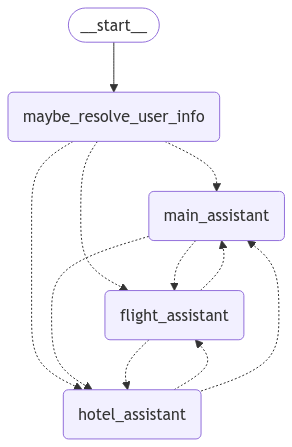

In [20]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [21]:
user_info = {f"user_{k}": v for k, v in USERS[0].items()}

In [22]:
import uuid
config = {"configurable": {"thread_id": str(uuid.uuid4()), "reservation_number": "1-123", **user_info}}

In [23]:
def print_stream(stream):
    for ns, update in stream:
        print(f"Namespace '{ns}'")
        for node, node_updates in update.items():
            if node_updates is None:
                continue

            if isinstance(node_updates, (dict, tuple)):
                node_updates_list = [node_updates]
            elif isinstance(node_updates, list):
                node_updates_list = node_updates
            else:
                raise ValueError(node_updates)

            for node_updates in node_updates_list:
                print(f"Update from node '{node}'")
                if isinstance(node_updates, tuple):
                    print(node_updates)
                    continue

                messages_key = next((k for k in node_updates.keys() if "messages" in k), None)
                if messages_key is not None:
                    node_updates[messages_key][-1].pretty_print()
                else:
                    print(node_updates)

        print("\n\n")

    print("\n===\n")

In [24]:
print_stream(workflow.stream(
    {"messages": [{"role": "user", "content": "hi, i'd like to book a flight"}]},
    config,
    subgraphs=True
))

Namespace '()'
Update from node 'maybe_resolve_user_info'
{'user_id': '1', 'user_last_name': 'Smith', 'user_first_name': 'John', 'user_title': 'Mr', 'reservation_number': '1-123', 'reservation_info': [{'number': '1-123', 'user_id': '1', 'flight_id': '1', 'hotel_id': '1', 'hotel_start_date': '2024-11-19', 'hotel_end_date': '2024-11-29', 'flight_info': {'departure_airport': 'BOS', 'arrival_airport': 'JFK', 'airline': 'Jet Blue', 'date': '2024-11-19'}, 'hotel_info': {'location': 'New York', 'name': 'McKittrick Hotel', 'neighborhood': 'Chelsea'}}]}



Namespace '('main_assistant:f67594bd-d7cd-aeb0-de4c-cda66ca08e70',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: main_assistant

Before we proceed with booking a new flight, I noticed that you have an existing reservation with the reservation number 1-123. Would you like to view or modify this reservation, or should we continue with booking a new flight?



Namespace '()'
Upd

In [26]:
print_stream(workflow.stream(
    {"messages": [{"role": "user", "content": "actually, i'd like to change my flight. want to fly to miami instead"}]},
    config,
    subgraphs=True
))

Namespace '()'



Namespace '('main_assistant:15138999-45d1-974a-6d54-00c0c948ed67',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: main_assistant

Since you want to modify your existing flight reservation, I will transfer you to the flight-booking assistant for further assistance with changing your flight to Miami.

Please hold on for a moment. Transferring now...
Tool Calls:
  transfer_to_flight_assistant (call_G2F3Mf5paUGd7QelmsLmGEek)
 Call ID: call_G2F3Mf5paUGd7QelmsLmGEek
  Args:



Namespace '()'
Update from node 'main_assistant'
{'user_id': '1'}
Update from node 'main_assistant'
{'user_title': 'Mr'}
Update from node 'main_assistant'
{'user_first_name': 'John'}
Update from node 'main_assistant'
{'user_last_name': 'Smith'}
Update from node 'main_assistant'
{'reservation_number': '1-123'}
Update from node 'main_assistant'
{'reservation_info': [{'number': '1-123', 'user_id': '1', 'flight_id': '1', 'hotel_id': '1', '

In [27]:
print_stream(workflow.stream(
    Command(resume=True),
    config,
    subgraphs=True
))

Namespace '('flight_assistant:21351ca5-965e-c988-b4a0-521ffc7d09fd',)'
Update from node 'tools'
================================= Tool Message =================================
Name: update_flight

Successfully updated reservation for the flight



Namespace '('flight_assistant:21351ca5-965e-c988-b4a0-521ffc7d09fd',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: flight_assistant

Your flight has been successfully changed. You are now booked on the American Airlines flight from Boston (BOS) to Miami (MIA) on November 19, 2024. If there's anything more I can assist you with, please let me know!



Namespace '()'
Update from node 'flight_assistant'
================================== Ai Message ==================================
Name: flight_assistant

Your flight has been successfully changed. You are now booked on the American Airlines flight from Boston (BOS) to Miami (MIA) on November 19, 2024. If there's anything more 

In [28]:
print_stream(workflow.stream(
    {"messages": [{"role": "user", "content": "now i'd like a hotel there as well"}]},
    config,
    subgraphs=True
))

Namespace '()'



Namespace '('flight_assistant:c6f99964-4557-d889-3e6d-c46017386693',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  transfer_to_hotel_assistant (call_uWNQLbNKrUv1TxY2GuNPAJb7)
 Call ID: call_uWNQLbNKrUv1TxY2GuNPAJb7
  Args:



Namespace '()'
Update from node 'flight_assistant'
{'user_id': '1'}
Update from node 'flight_assistant'
{'user_title': 'Mr'}
Update from node 'flight_assistant'
{'user_first_name': 'John'}
Update from node 'flight_assistant'
{'user_last_name': 'Smith'}
Update from node 'flight_assistant'
{'reservation_number': '1-123'}
Update from node 'flight_assistant'
{'reservation_info': [{'number': '1-123', 'user_id': '1', 'flight_id': '2', 'hotel_id': '1', 'hotel_start_date': '2024-11-19', 'hotel_end_date': '2024-11-29', 'flight_info': {'departure_airport': 'BOS', 'arrival_airport': 'MIA', 'airline': 'American Airlines', 'date': '2024-11-19'}, 'hotel_info': {'

In [29]:
print_stream(workflow.stream(
    {"messages": [{"role": "user", "content": "how about miami beach?"}]},
    config,
    subgraphs=True
))

Namespace '()'



Namespace '('hotel_assistant:88ade28b-91ec-72e4-0770-273b49c3d7ce',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: hotel_assistant
Tool Calls:
  search_hotels (call_WN4kc0ftCWimucvWajCxzqUj)
 Call ID: call_WN4kc0ftCWimucvWajCxzqUj
  Args:
    location: Miami Beach



Namespace '('hotel_assistant:88ade28b-91ec-72e4-0770-273b49c3d7ce',)'
Update from node 'tools'
================================= Tool Message =================================
Name: search_hotels

[{"id": "3", "location": "Miami Beach", "name": "Nautilus Hotel", "neighborhood": "South Beach"}]



Namespace '('hotel_assistant:88ade28b-91ec-72e4-0770-273b49c3d7ce',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: hotel_assistant

I found a hotel for you in Miami Beach:

- **Nautilus Hotel** located in the South Beach neighborhood.

Would you like to book this hotel?



Namespac

In [30]:
print_stream(workflow.stream(
    {"messages": [{"role": "user", "content": "yes"}]},
    config,
    subgraphs=True
))

Namespace '()'



Namespace '('hotel_assistant:1598d60c-78f8-20e9-d39a-08b4e5d6b9a9',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: hotel_assistant
Tool Calls:
  book_hotel (call_ihaQfLtp0TZDa1JDMMgLanc2)
 Call ID: call_ihaQfLtp0TZDa1JDMMgLanc2
  Args:
    hotel_id: 3
    mode: update



Namespace '('hotel_assistant:1598d60c-78f8-20e9-d39a-08b4e5d6b9a9',)'
Update from node 'tools'
================================= Tool Message =================================
Name: book_hotel

Successfully added a reservation for the hotel



Namespace '('hotel_assistant:1598d60c-78f8-20e9-d39a-08b4e5d6b9a9',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: hotel_assistant

Your hotel reservation has been successfully updated. You are now booked at the Nautilus Hotel in the South Beach neighborhood of Miami Beach.

If there's anything else you need assistance with, just 

In [30]:
# print_stream(workflow.stream(
#     Command(resume=True),
#     config,
#     subgraphs=True
# ))


===



In [31]:
workflow.get_state(config).values["reservation_info"]

[{'number': '1-123',
  'user_id': '1',
  'flight_id': '2',
  'hotel_id': '3',
  'hotel_start_date': '2024-11-19',
  'hotel_end_date': '2024-11-29',
  'flight_info': {'departure_airport': 'BOS',
   'arrival_airport': 'MIA',
   'airline': 'American Airlines',
   'date': '2024-11-19'},
  'hotel_info': {'location': 'Miami Beach',
   'name': 'Nautilus Hotel',
   'neighborhood': 'South Beach'}}]

In [37]:
for m in workflow.get_state(config).values["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi, i'd like to book a flight
================================== Ai Message ==================================
Name: main_assistant

Before we proceed with booking a new flight, I noticed that you have an existing reservation with the reservation number 1-123. Would you like to view or modify this reservation, or should we continue with booking a new flight?
================================ Human Message =================================

actually, i'd like to change my flight. want to fly to miami instead
================================== Ai Message ==================================
Name: main_assistant

Since you want to modify your existing flight reservation, I will transfer you to the flight-booking assistant for further assistance with changing your flight to Miami.

Please hold on for a moment. Transferring now...
Tool Calls:
  transfer_to_flight_assistant (call_G2F3Mf5paUGd7QelmsLmGEek)
 Call ID

## Custom setup with private messages state

This setup shows how to do:
- handoffs that provide task descriptions (not necessary but nice to remove internal agent message history)
- decouples internal agent messages state key from multi-agent state (ie makes it private). This requires wrapping the agent in a factory to convert from/to parent messages

#### Define custom handoff tool

In [39]:
import re
from typing_extensions import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import BaseTool, StructuredTool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command


WHITESPACE_RE = re.compile(r"\s+")
METADATA_KEY_HANDOFF_DESTINATION = "__handoff_destination"


def _normalize_agent_name(agent_name: str) -> str:
    return WHITESPACE_RE.sub("_", agent_name.strip()).lower()



def task_description_handoff_tool(*, agent_name: str, description: str | None = None) -> BaseTool:
    name = f"transfer_to_{_normalize_agent_name(agent_name)}"
    if description is None:
        description = f"Ask agent '{agent_name}' for help"

    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
        task_description: str,
    ):
        """Ask agent for help.

        Args:
            task_description: detailed description of what the next agent should do, including all of the relevant context.
        """
        tool_message = ToolMessage(
            content=f"Successfully transferred to {agent_name}",
            name=name,
            tool_call_id=tool_call_id,
        )

        # this is a hack
        messages_key = next(key for key in state.keys() if "messages" in key)
        return Command(
            goto=agent_name,
            graph=Command.PARENT,
            update={
                "messages": [state[messages_key][-1], tool_message],
                "active_agent": agent_name,
            }
        )

    handoff_tool = StructuredTool.from_function(
        name=name,
        description=description,
        func=handoff_to_agent,
        metadata={METADATA_KEY_HANDOFF_DESTINATION: agent_name},
    )
    return handoff_tool

### Define custom react agent (`create_react_agent` + `messages_key`)

In [40]:
from typing_extensions import Literal
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.prebuilt import ToolNode
from langgraph.types import Command

# basically same as create_react_agent
# but with customizable messages_key
def custom_react_agent(
    model, 
    tools, 
    *, 
    prompt=None,
    name=None,
    state_schema=AgentState,
    messages_key="messages"
):
    model_with_tools = model.bind_tools(tools)
    tool_node = ToolNode(tools, messages_key=messages_key)

    def call_model(state) -> Command[Literal["tools", "__end__"]]:
        messages = state[messages_key]
        if prompt:
            if isinstance(prompt, str):
                messages = [{"role": "system", "content": prompt}] + messages
            elif callable(prompt):
                messages = prompt(state, config)

        response = model_with_tools.invoke(messages)
        response.name = name
        if len(response.tool_calls) > 0:
            return Command(goto="tools", update={messages_key: [response]})

        return {messages_key: [response]}

    graph = StateGraph(state_schema)
    graph.add_node("process_input", call_model)
    graph.add_node("model", call_model)
    graph.add_node("tools", tool_node)
    graph.add_edge(START, "model")
    graph.add_edge("tools", "model")
    return graph.compile(name=name)

#### Define the agent wrapper

In [41]:
from typing_extensions import TypedDict, Annotated
from langchain_core.messages import AnyMessage, AIMessage


def make_call_agent(agent, messages_key):
    def call_agent(state):
        # example: process input for custom task description tools
        if (
            len(state["messages"]) >= 2 
            and isinstance(state["messages"][-1], ToolMessage)
            and isinstance(state["messages"][-2], AIMessage)
        ):
            tool_calls = state["messages"][-2].tool_calls
            if len(tool_calls) == 1 and "task_description" in tool_calls[0]["args"]:
                input_ = {**state, messages_key: tool_calls[0]["args"]["task_description"]}
            else:
                raise ValueError(state)
        else:
            input_ = {**state, messages_key: state["messages"]}
        
        response = agent.invoke(input_)
        # process output (keep only last message)
        return {**response, "messages": response[messages_key][-1:]}

    return call_agent

In [42]:
transfer_to_hotel_assistant = task_description_handoff_tool(
    agent_name="hotel_assistant",
    description="Transfer user to the hotel-booking assistant that can create/update or cancel bookings."
)
transfer_to_flight_assistant = task_description_handoff_tool(
    agent_name="flight_assistant",
    description="Transfer user to the flight-booking assistant that can create/update or cancel bookings."
)
transfer_to_main_assistant = task_description_handoff_tool(
    agent_name="main_assistant",
    description="Transfer user to the main travel booking assistant if you don't know how to help the user."
)

In [43]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, AIMessage
from langgraph.managed import IsLastStep, RemainingSteps

class MainAgentState(State):
    main_messages: Annotated[list[AnyMessage], add_messages]
    remaining_steps: RemainingSteps


class FlightAgentState(State):
    flight_messages: Annotated[list[AnyMessage], add_messages]
    remaining_steps: RemainingSteps
    

class HotelAgentState(State):
    hotel_messages: Annotated[list[AnyMessage], add_messages]
    remaining_steps: RemainingSteps


main_assistant_tools = [verify_user_information, transfer_to_flight_assistant, transfer_to_hotel_assistant]
main_assistant = custom_react_agent(
    model.bind_tools(main_assistant_tools, parallel_tool_calls=False),
    main_assistant_tools,
    state_schema=MainAgentState,
    messages_key="main_messages",
    prompt=make_prompt(MAIN_ASSISTANT_SYSTEM_PROMPT, "main_messages"),
    name="main_assistant",
)

flight_assistant_tools = make_flight_tools("flight_messages") + [transfer_to_hotel_assistant, transfer_to_main_assistant]
flight_assistant = custom_react_agent(
    model.bind_tools(flight_assistant_tools, parallel_tool_calls=False),
    flight_assistant_tools,
    state_schema=FlightAgentState,
    messages_key="flight_messages",
    prompt=make_prompt("You are a flight booking assistant", "flight_messages"),
    name="flight_assistant"
)

hotel_assistant_tools = make_hotel_tools("hotel_messages") + [transfer_to_flight_assistant, transfer_to_main_assistant]
hotel_assistant = custom_react_agent(
    model.bind_tools(hotel_assistant_tools, parallel_tool_calls=False),
    hotel_assistant_tools,
    state_schema=HotelAgentState,
    messages_key="hotel_messages",
    prompt=make_prompt("You are a hotel booking assistant", "hotel_messages"),
    name="hotel_assistant"
)

In [44]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

checkpointer = MemorySaver()
agent_names = [main_assistant.name, flight_assistant.name, hotel_assistant.name]
workflow = (
    # NOTE: manually adding router here
    add_active_agent_router(
        StateGraph(MultiAgentState), 
        route_to=agent_names,
        route_from="maybe_resolve_user_info",
        default_active_agent=main_assistant.name
    )
    .add_node(
        main_assistant.name, 
        make_call_agent(main_assistant, "main_messages"), 
        destinations=(hotel_assistant.name, flight_assistant.name)
    )
    .add_node(
        hotel_assistant.name, 
        make_call_agent(hotel_assistant, "hotel_messages"), 
        destinations=(main_assistant.name, flight_assistant.name)
    )
    .add_node(
        flight_assistant.name, 
        make_call_agent(flight_assistant, "flight_messages"), 
        destinations=(main_assistant.name, hotel_assistant.name)
    )
    .add_edge(START, "maybe_resolve_user_info")
    .add_node(maybe_resolve_user_info)
    .compile(checkpointer=checkpointer)
)

In [45]:
from IPython.display import display, Image

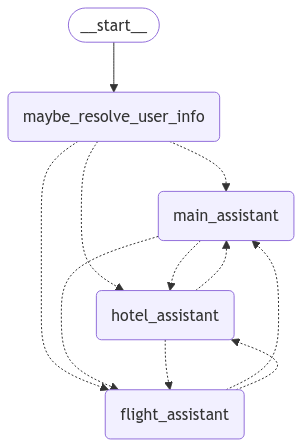

In [46]:
display(Image(workflow.get_graph().draw_mermaid_png()))

---

In [47]:
config = {"configurable": {"thread_id": str(uuid.uuid4()), "reservation_number": "1-123", **user_info}}

print_stream(workflow.stream(
    {"messages": [{"role": "user", "content": "hi, i'd like to book a flight"}]},
    config,
    subgraphs=True
))

Namespace '()'
Update from node 'maybe_resolve_user_info'
{'user_id': '1', 'user_last_name': 'Smith', 'user_first_name': 'John', 'user_title': 'Mr', 'reservation_number': '1-123', 'reservation_info': [{'number': '1-123', 'user_id': '1', 'flight_id': '1', 'hotel_id': '1', 'hotel_start_date': '2024-11-19', 'hotel_end_date': '2024-11-29', 'flight_info': {'departure_airport': 'BOS', 'arrival_airport': 'JFK', 'airline': 'Jet Blue', 'date': '2024-11-19'}, 'hotel_info': {'location': 'New York', 'name': 'McKittrick Hotel', 'neighborhood': 'Chelsea'}}]}



Namespace '('main_assistant:b2e36cec-8806-c1ae-e00a-1e603d565443',)'
Update from node 'model'
================================== Ai Message ==================================
Name: main_assistant

I see that you have an existing reservation with the flight scheduled from BOS to JFK on 2024-11-19 with Jet Blue. Would you like to update or cancel this flight, or would you like to book a new one?



Namespace '()'
Update from node 'main_assistan

In [48]:
print_stream(workflow.stream(
    {"messages": [{"role": "user", "content": "actually, i'd like to change my flight. want to fly to miami instead"}]},
    config,
    subgraphs=True
))

Namespace '()'



Namespace '('main_assistant:3bbe2a8c-e3a3-8893-c356-bc98984065e4',)'
Update from node 'model'
================================== Ai Message ==================================
Name: main_assistant
Tool Calls:
  transfer_to_flight_assistant (call_7TbpATtPYPUO1ymEOGKNj3VP)
 Call ID: call_7TbpATtPYPUO1ymEOGKNj3VP
  Args:
    task_description: Change the existing flight reservation from BOS to JFK on 2024-11-19 with Jet Blue to a flight to Miami instead.



Namespace '()'
Update from node 'main_assistant'
================================= Tool Message =================================
Name: transfer_to_flight_assistant

Successfully transferred to flight_assistant



Namespace '('flight_assistant:ec0cea5d-4fe3-ce82-2cd1-8eadaa60acb9',)'
Update from node 'model'
================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  search_flights (call_6DZKyAULxOhuvm2XSMi5lJS3)
 Call ID: call_6DZKyAULxOhuvm2XSMi5lJS3
  Args:
  

In [49]:
print_stream(workflow.stream(
    Command(resume=True),
    config,
    subgraphs=True
))

Namespace '('flight_assistant:ec0cea5d-4fe3-ce82-2cd1-8eadaa60acb9',)'
Update from node 'tools'
================================= Tool Message =================================
Name: update_flight

Successfully updated reservation for the flight



Namespace '('flight_assistant:ec0cea5d-4fe3-ce82-2cd1-8eadaa60acb9',)'
Update from node 'model'
================================== Ai Message ==================================
Name: flight_assistant

Your flight reservation has been successfully updated to a flight from Boston (BOS) to Miami (MIA) with American Airlines on November 19, 2024. If there's anything else you need assistance with, feel free to let me know!



Namespace '()'
Update from node 'flight_assistant'
================================== Ai Message ==================================
Name: flight_assistant

Your flight reservation has been successfully updated to a flight from Boston (BOS) to Miami (MIA) with American Airlines on November 19, 2024. If there's anything else y

In [50]:
print_stream(workflow.stream(
    {"messages": [{"role": "user", "content": "now i'd like a hotel there as well"}]},
    config,
    subgraphs=True
))

Namespace '()'



Namespace '('flight_assistant:4a05ac1e-561e-708e-84c9-600936a0524a',)'
Update from node 'model'
================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  transfer_to_hotel_assistant (call_JtajKnd0RMS4z9Y34G2P1O8G)
 Call ID: call_JtajKnd0RMS4z9Y34G2P1O8G
  Args:
    task_description: Book a hotel in Miami from November 19, 2024, to November 29, 2024, for Mr John Smith.



Namespace '()'
Update from node 'flight_assistant'
================================= Tool Message =================================
Name: transfer_to_hotel_assistant

Successfully transferred to hotel_assistant



Namespace '('hotel_assistant:9653dc05-7938-e093-dc65-3273071d2a71',)'
Update from node 'model'
================================== Ai Message ==================================
Name: hotel_assistant
Tool Calls:
  search_hotels (call_RcOauEap4JoEw9D28LWWXczx)
 Call ID: call_RcOauEap4JoEw9D28LWWXczx
  Args:
    location: Miami



Names

In [51]:
print_stream(workflow.stream(
    {"messages": [{"role": "user", "content": "how about miami beach?"}]},
    config,
    subgraphs=True
))

Namespace '()'



Namespace '('hotel_assistant:e4d20a0a-ab5e-b4c0-ebc5-3655e4c0811a',)'
Update from node 'model'
================================== Ai Message ==================================
Name: hotel_assistant
Tool Calls:
  search_hotels (call_gQc4wJnUUoYbGe2HyursEkBX)
 Call ID: call_gQc4wJnUUoYbGe2HyursEkBX
  Args:
    location: Miami Beach



Namespace '('hotel_assistant:e4d20a0a-ab5e-b4c0-ebc5-3655e4c0811a',)'
Update from node 'tools'
================================= Tool Message =================================
Name: search_hotels

[{"id": "3", "location": "Miami Beach", "name": "Nautilus Hotel", "neighborhood": "South Beach"}]



Namespace '('hotel_assistant:e4d20a0a-ab5e-b4c0-ebc5-3655e4c0811a',)'
Update from node 'model'
================================== Ai Message ==================================
Name: hotel_assistant

I found a hotel in Miami Beach for your stay:

- **Nautilus Hotel** in South Beach

Would you like to book this hotel for your stay from November 19, 

In [52]:
print_stream(workflow.stream(
    {"messages": [{"role": "user", "content": "yes"}]},
    config,
    subgraphs=True
))

Namespace '()'



Namespace '('hotel_assistant:81fd83ea-aa37-c943-e9bb-58cefa10f601',)'
Update from node 'model'
================================== Ai Message ==================================
Name: hotel_assistant
Tool Calls:
  book_hotel (call_eNCcxSig3wMFH2Udb4lGRkGr)
 Call ID: call_eNCcxSig3wMFH2Udb4lGRkGr
  Args:
    hotel_id: 3
    mode: update



Namespace '('hotel_assistant:81fd83ea-aa37-c943-e9bb-58cefa10f601',)'
Update from node 'tools'
================================= Tool Message =================================
Name: book_hotel

Successfully added a reservation for the hotel



Namespace '('hotel_assistant:81fd83ea-aa37-c943-e9bb-58cefa10f601',)'
Update from node 'model'
================================== Ai Message ==================================
Name: hotel_assistant

Your hotel reservation at Nautilus Hotel in South Beach, Miami Beach, from November 19, 2024, to November 29, 2024, has been successfully updated. If there's anything else you need, feel free to let m

In [53]:
workflow.get_state(config).values["reservation_info"]

[{'number': '1-123',
  'user_id': '1',
  'flight_id': '2',
  'hotel_id': '3',
  'hotel_start_date': '2024-11-19',
  'hotel_end_date': '2024-11-29',
  'flight_info': {'departure_airport': 'BOS',
   'arrival_airport': 'MIA',
   'airline': 'American Airlines',
   'date': '2024-11-19'},
  'hotel_info': {'location': 'Miami Beach',
   'name': 'Nautilus Hotel',
   'neighborhood': 'South Beach'}}]

In [54]:
for m in workflow.get_state(config).values["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi, i'd like to book a flight
================================== Ai Message ==================================
Name: main_assistant

I see that you have an existing reservation with the flight scheduled from BOS to JFK on 2024-11-19 with Jet Blue. Would you like to update or cancel this flight, or would you like to book a new one?
================================ Human Message =================================

actually, i'd like to change my flight. want to fly to miami instead
================================== Ai Message ==================================
Name: main_assistant
Tool Calls:
  transfer_to_flight_assistant (call_7TbpATtPYPUO1ymEOGKNj3VP)
 Call ID: call_7TbpATtPYPUO1ymEOGKNj3VP
  Args:
    task_description: Change the existing flight reservation from BOS to JFK on 2024-11-19 with Jet Blue to a flight to Miami instead.
================================= Tool Message ===========================

---